In [18]:
from PIL import Image
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
import onnx

import cv2

In [19]:
model_path = '../model/zfnet512-12.onnx'
model = onnx.load(model_path)
ort_session  = ort.InferenceSession(model.SerializeToString())

In [20]:
def preprocess(image):
    # resize so that the shorter side is 256, maintaining aspect ratio
    def image_resize(image, min_len):
        image = Image.fromarray(image)
        ratio = float(min_len) / min(image.size[0], image.size[1])
        if image.size[0] > image.size[1]:
            new_size = (int(round(ratio * image.size[0])), min_len)
        else:
            new_size = (min_len, int(round(ratio * image.size[1])))
        image = image.resize(new_size, Image.BILINEAR)
        return np.array(image)
    image = image_resize(image, 256)

    # Crop centered window 224x224
    def crop_center(image, crop_w, crop_h):
        h, w, c = image.shape
        start_x = w//2 - crop_w//2
        start_y = h//2 - crop_h//2
        return image[start_y:start_y+crop_h, start_x:start_x+crop_w, :]
    image = crop_center(image, 224, 224)

    # transpose
    image = image.transpose(2, 0, 1)

    # convert the input data into the float32 input
    img_data = image.astype('float32')

    # normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

    # add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

In [21]:
def get_image(path, show=False):
    with Image.open(path) as img:
        img = np.array(img.convert('RGB'))
    if show:
        plt.imshow(img)
        plt.axis('off')
    return img

In [22]:
def predict(path):
    img = get_image(path, show=True)
    img = preprocess(img)
    
    # 推理
    output = ort_session .run(['gpu_0/softmax_1'], {'gpu_0/data_0': img})
    
    # 获取预测结果
    predictions = output[0]

    # 处理预测结果
    predicted_class = np.argmax(predictions)
    predicted_probability = predictions[0, predicted_class]

    print("Predicted Class:", predicted_class)
    print("Predicted Probability:", predicted_probability)




C:\Users\Chn\AppData\Local\Temp\ipykernel_19084\3032287635.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize(new_size, Image.BILINEAR)


Predicted Class: 124
Predicted Probability: 0.045759384


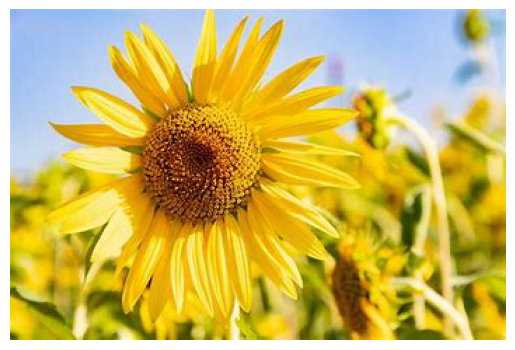

In [23]:
img_path = '../picture/OIP-C.jpg'
predict(img_path)